In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.append('..')

from src import config
from src import utils as us
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_style('white')

In [4]:
import pandas as pd
import numpy as np
import MACS3 as macs
import cv2
import shutil
from itertools import product

In [5]:
! ls ../data/peaks/
! du -sh ../data/annotations/*

IDR_summit_intersection.log  REP2_model.pdf	    REPS_formatted.bed
REP1.log		     REP2_model.r	    REPS_model.r
REP1_model.pdf		     REP2_peaks.narrowPeak  REPS_peaks.narrowPeak
REP1_model.r		     REP2_peaks.xls	    REPS_peaks.xls
REP1_peaks.narrowPeak	     REP2_summits.bed	    REPS_summits.bed
REP1_peaks.xls		     REPS.log		    summit_intersection.log
REP1_summits.bed	     REPS_all.log
REP2.log		     REPS_blacklisted.bed
6.0M	../data/annotations/DNase.bed
9.1M	../data/annotations/ENCFF123MSN.bigBed
5.9M	../data/annotations/ENCFF808IZE.bed.gz
2.3M	../data/annotations/IDR_NARROWPEAKS_REP12.bed
1.7M	../data/annotations/IDR_NARROWPEAKS_REP12.bigBed
2.3M	../data/annotations/SUMMITS_REP12.bed
4.0K	../data/annotations/rename.sh


In [6]:
! cat ../data/annotations/rename.sh

#!/bin/bash

mv ENCFF810LSF.bed.gz IDR_NARROWPEAKS_REP12.bed.gz
mv ENCFF424RNN.bigBed IDR_NARROWPEAKS_REP12.bigBed



### Peacks in each try:

In [7]:
! echo "REP1: `cat ../data/peaks/REP1_peaks.narrowPeak | wc -l`"
! echo "REP2: `cat ../data/peaks/REP2_peaks.narrowPeak | wc -l`"
! echo "POOLED REPS1&2: `cat ../data/peaks/REPS_peaks.narrowPeak | wc -l`"
! echo "ENCODE: `cat ../data/annotations/IDR_NARROWPEAKS_REP12.bed | wc -l`"

REP1: 51771
REP2: 40667
POOLED REPS1&2: 37379
ENCODE: 37951


### Peaks in common of both REPS:

In [8]:
! bedtools intersect -a ../data/peaks/REP1_peaks.narrowPeak -b ../data/peaks/REP2_peaks.narrowPeak > ../data/intersection/REP1_REP2.bed
! echo "REP1 & REP2: `cat ../data/intersection/REP1_REP2.bed | wc -l`"

REP1 & REP2: 35595


### Peaks in common between REPS & ENCODE:

In [9]:
! bedtools intersect -u -a ../data/peaks/REP1_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/REP1_ENCODE.bed
! echo "REP1 & ENCODE: `cat ../data/intersection/REP1_ENCODE.bed | wc -l`"

! bedtools intersect -u -a ../data/peaks/REP2_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/REP2_ENCODE.bed
! echo "REP2 & ENCODE: `cat ../data/intersection/REP2_ENCODE.bed | wc -l`"

! bedtools intersect -u -a ../data/intersection/REP1_REP2.bed -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/REP1_REP2_ENCODE.bed
! echo "REP1 & REP2 & ENCODE: `cat ../data/intersection/REP1_REP2_ENCODE.bed | wc -l`"

! bedtools intersect -u -a ../data/peaks/REPS_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/REPS_ENCODE.bed
! echo "POOLED REPS & ENCODE: `cat ../data/intersection/REPS_ENCODE.bed | wc -l`"

REP1 & ENCODE: 24246
REP2 & ENCODE: 21897
REP1 & REP2 & ENCODE: 22437
POOLED REPS & ENCODE: 22441


In [10]:
! bedtools subtract -A -a ../data/peaks/REP1_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/NON_REP1_ENCODE.bed
! bedtools subtract -A -a ../data/peaks/REP2_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/NON_REP2_ENCODE.bed
! bedtools subtract -A -a ../data/intersection/REP1_REP2.bed -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/NON_REP1_REP2_ENCODE.bed
! bedtools subtract -A -a ../data/peaks/REPS_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/NON_REPS_ENCODE.bed

In [11]:
names = [ 'REP1_ENCODE', 'REP2_ENCODE', 'REPS_ENCODE' ]
qvals = us.get_qvals(names, True)

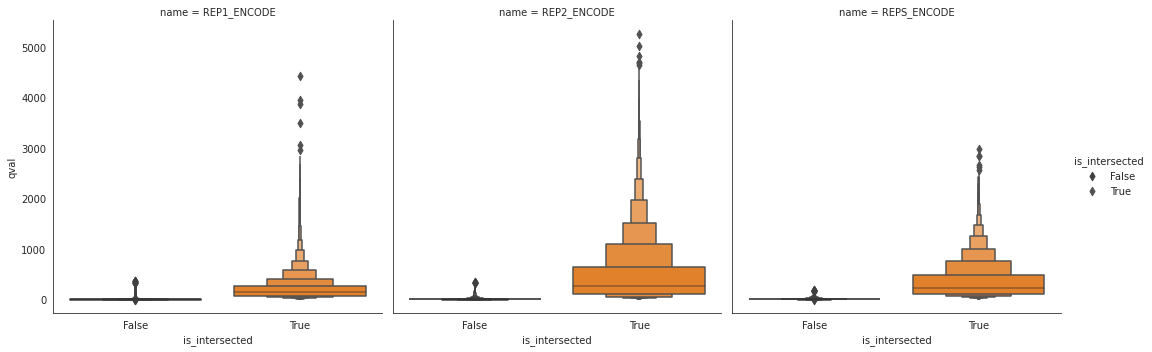

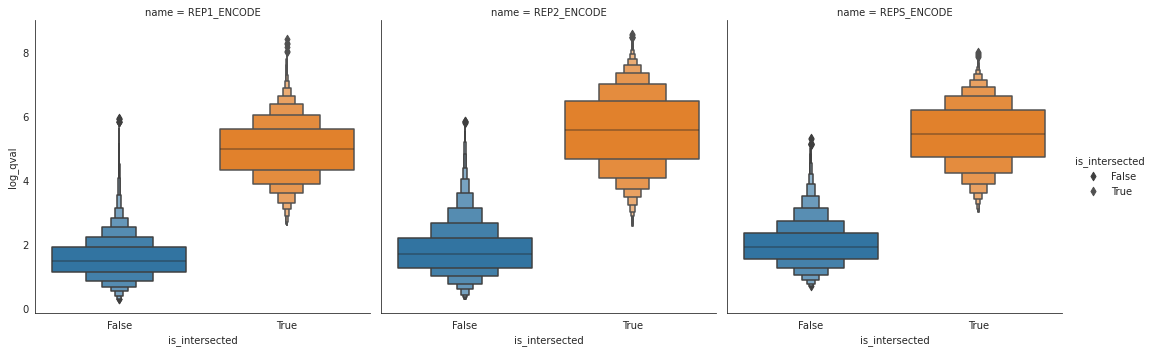

In [12]:
g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'qval_intersect.png')

g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "log_qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'log_qval_intersect.png')

### Peaks Summit Overlay

In [13]:
with open('../data/annotations/SUMMITS_REP12.bed', 'w') as wd:
    with open('../data/annotations/IDR_NARROWPEAKS_REP12.bed', 'r') as fd:
        lines = fd.readlines()
        for line in lines:
            tmp = line.split()
            tmp[2] = int(tmp[1]) + int(tmp[-1]) + 1
            tmp[1] = int(tmp[1]) + int(tmp[-1])
            wd.write('\t'.join(map(str, tmp)) + '\n')

In [14]:
! bedtools window -u -w 150 -a ../data/peaks/REP1_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/SUMMIT_REP1_ENCODE.bed
! echo "REP1 & ENCODE: `cat ../data/intersection/SUMMIT_REP1_ENCODE.bed | wc -l`"

! bedtools window -u -w 150 -a ../data/peaks/REP2_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/SUMMIT_REP2_ENCODE.bed
! echo "REP2 & ENCODE: `cat ../data/intersection/SUMMIT_REP2_ENCODE.bed | wc -l`"

! bedtools window -u -w 150 -a ../data/peaks/REPS_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/SUMMIT_REPS_ENCODE.bed
! echo "POOLED REPS & ENCODE: `cat ../data/intersection/SUMMIT_REPS_ENCODE.bed | wc -l`"

REP1 & ENCODE: 20741
REP2 & ENCODE: 19270
POOLED REPS & ENCODE: 20121


In [15]:
! bedtools window -v -w 150 -a ../data/peaks/REP1_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/NON_SUMMIT_REP1_ENCODE.bed
! echo "REP1 & ENCODE: `cat ../data/intersection/NON_SUMMIT_REP1_ENCODE.bed | wc -l`"

! bedtools window -v -w 150 -a ../data/peaks/REP2_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/NON_SUMMIT_REP2_ENCODE.bed
! echo "REP2 & ENCODE: `cat ../data/intersection/NON_SUMMIT_REP2_ENCODE.bed | wc -l`"

! bedtools window -v -w 150 -a ../data/peaks/REPS_summits.bed -b ../data/annotations/SUMMITS_REP12.bed > ../data/intersection/NON_SUMMIT_REPS_ENCODE.bed
! echo "POOLED REPS & ENCODE: `cat ../data/intersection/NON_SUMMIT_REPS_ENCODE.bed | wc -l`"

REP1 & ENCODE: 31030
REP2 & ENCODE: 21397
POOLED REPS & ENCODE: 17258


In [16]:
names=[ 
    'SUMMIT_REP1_ENCODE', 'SUMMIT_REP2_ENCODE', 'SUMMIT_REPS_ENCODE' ]
qvals = us.get_qvals(names)
qvals.head()

,qval,is_intersected,name,log_qval
0,38.12303,True,SUMMIT_REP1_ENCODE,3.640819
1,97.20737,True,SUMMIT_REP1_ENCODE,4.576847
2,7.25432,True,SUMMIT_REP1_ENCODE,1.981597
3,3.81707,True,SUMMIT_REP1_ENCODE,1.339483
4,11.17720,True,SUMMIT_REP1_ENCODE,2.413876


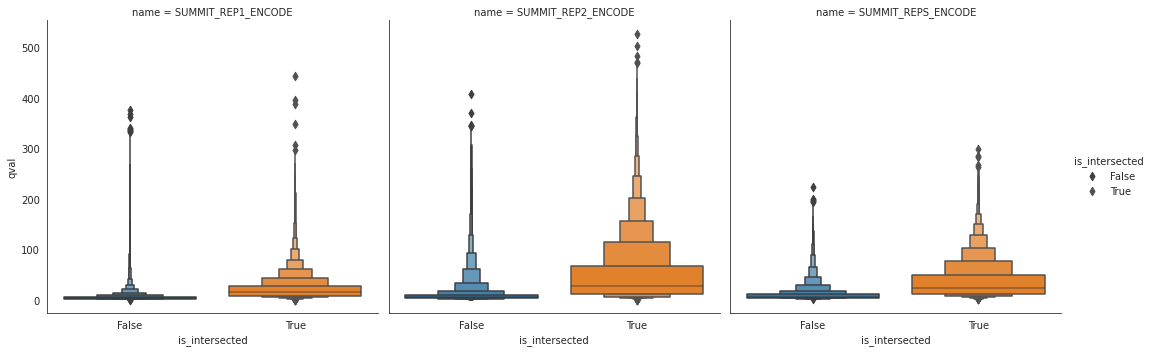

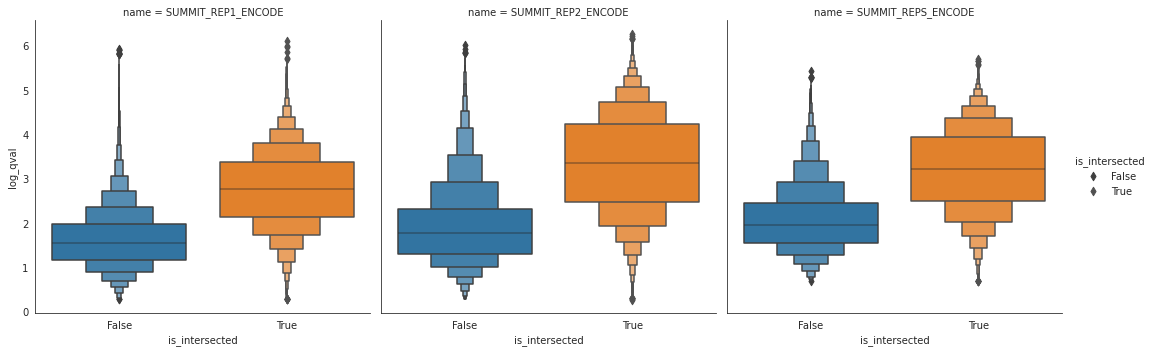

In [17]:
g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'ps_qval_intersect.png')

g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "log_qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'log_ps_qval_intersect.png')

# IDR estimation

In [40]:
! for REP in "REP1" "REP2"; do \
    macs2 callpeak \
        -t ../data/input/${REP}.bam \
        -c ../data/control/CONTROL.bam \
        -f BAM -g hs -n ../data/IDR/${REP} -B -p 1e-1  2> ../data/IDR/${REP}.log; \
    head ../data/IDR/${REP}.log; \
    sort -k8,8nr ../data/IDR/${REP}_peaks.narrowPeak  > ../data/IDR/SORTED_${REP}_peaks.narrowPeak; \
    done;

INFO  @ Sat, 02 Apr 2022 10:44:35: 
# Command line: callpeak -t ../data/input/REP1.bam -c ../data/control/CONTROL.bam -f BAM -g hs -n ../data/IDR/REP1 -B -p 1e-2
# ARGUMENTS LIST:
# name = ../data/IDR/REP1
# format = BAM
# ChIP-seq file = ['../data/input/REP1.bam']
# control file = ['../data/control/CONTROL.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
INFO  @ Sat, 02 Apr 2022 10:52:04: 
# Command line: callpeak -t ../data/input/REP2.bam -c ../data/control/CONTROL.bam -f BAM -g hs -n ../data/IDR/REP2 -B -p 1e-2
# ARGUMENTS LIST:
# name = ../data/IDR/REP2
# format = BAM
# ChIP-seq file = ['../data/input/REP2.bam']
# control file = ['../data/control/CONTROL.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]


In [46]:
! for REP in "REP1" "REP2"; do \
    bedtools subtract -A -a ../data/IDR/SORTED_${REP}_peaks.narrowPeak -b ../data/blacklist/hg38.blacklist.bed.gz > ../data/IDR/${REP}_blacklisted.bed; \
    echo "Peaks called for ${REP}: `cat ../data/IDR/SORTED_${REP}_peaks.narrowPeak | wc -l`"; \
    echo "Afteк blacklist: `cat ../data/IDR/${REP}_blacklisted.bed | wc -l`"; \
    done;

Peaks called for REP1: 129911
Afte blacklist: 129905
Peaks called for REP2: 88074
Afte blacklist: 88054


In [60]:
! idr -i 0.2 --samples ../data/IDR/SORTED_REP1_peaks.narrowPeak ../data/IDR/SORTED_REP2_peaks.narrowPeak \
    --input-file-type narrowPeak \
    --rank p.value \
    --output-file ../data/IDR/RESULT \
    --plot \
    --log-output-file ../data/IDR/RESULT.log
! cat ../data/IDR/RESULT.log

Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.52 0.63 0.76 0.40]
Number of reported peaks - 23649/48857 (48.4%)

Number of peaks passing IDR cutoff of 0.2 - 23649/48857 (48.4%)



PosixPath('../data/assets/IDR_RESULT.png')

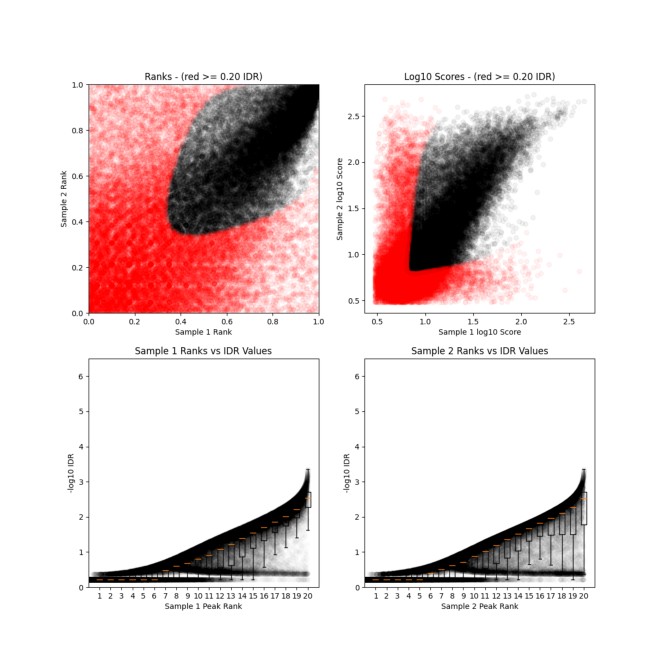

In [37]:
plt.figure(figsize=(12, 12))
im = cv2.imread(str(config.PATHS.DATA/'IDR/RESULT.png'))[..., ::-1]
plt.imshow(im);
plt.axis('off');

shutil.copyfile(
    config.PATHS.DATA/'IDR/RESULT.png', 
    config.PATHS.ASSETS/'IDR_RESULT.png')

In [66]:
! cat '../data/IDR/RESULT' | wc -l
! cat '../data/annotations/IDR_NARROWPEAKS_REP12.bed' | wc -l

23649
37951


In [65]:
! bedtools intersect -a ../data/IDR/RESULT -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/IDR_ENCODE.bed
! echo "IDR .2 THRESHOLDED & ENCODE: `cat ../data/intersection/IDR_ENCODE.bed | wc -l`"

IDR .2 THRESHOLDED & ENCODE: 26864


# UCSC Visualisation

In [31]:
! bedtools intersect -a ../data/peaks/REPS_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/REPS_ENCODE.bed
! bedtools subtract -A -a ../data/peaks/REPS_peaks.narrowPeak -b ../data/annotations/IDR_NARROWPEAKS_REP12.bed > ../data/intersection/NON_REPS_ENCODE.bed
! bedtools subtract -A -a ../data/annotations/IDR_NARROWPEAKS_REP12.bed -b ../data/peaks/REPS_peaks.narrowPeak > ../data/intersection/NON_ENCODE_REPS.bed

In [32]:
np_header = [ 
    'chrom', 'chromStart', 'chromEnd', 'name', 
    'score', 'strand', 'signalValue', 'pValue', 'qval', 'peak' ]

def read_np(path):
    data = pd.read_csv(path, sep='\t', header=None)
    data.columns = np_header
    return data

intersect = read_np('../data/intersection/REPS_ENCODE.bed')
exclude = read_np('../data/intersection/NON_REPS_ENCODE.bed')
non_included = read_np('../data/intersection/NON_ENCODE_REPS.bed')
intersect.head()

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qval,peak
0,chr1,778568,779254,REPS_peak_23,450,.,7.43683,48.25445,45.04950,602
1,chr1,827264,827635,REPS_peak_25,1066,.,16.56221,110.67361,106.65491,707
2,chr1,869905,870159,REPS_peak_28,502,.,13.02266,53.49247,50.20856,211
3,chr1,904446,904942,REPS_peak_29,289,.,7.82464,31.89886,28.96556,318
4,chr1,921100,921421,REPS_peak_32,215,.,5.77943,24.34951,21.56016,166


In [28]:
intearsect.sort_values('signalValue', ascending=False).head()

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qval,peak
3492,chr10,22325566,22326108,REPS_peak_3867,2982,.,57.18634,307.70874,298.21759,516
3319,chr10,135659,136510,REPS_peak_3692,2840,.,49.49109,291.80121,284.03433,1566
3320,chr10,134612,134974,REPS_peak_3692,2840,.,49.49109,291.80121,284.03433,1566
3321,chr10,135659,136510,REPS_peak_3692,2840,.,49.49109,291.80121,284.03433,1566
3322,chr10,134721,135417,REPS_peak_3692,2840,.,49.49109,291.80121,284.03433,1566


In [30]:
exclude.sort_values('signalValue', ascending=False).head()

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qval,peak
4247,chr15,30470714,30471924,REPS_peak_10421,2003,.,31.54875,205.92921,200.35512,450
9680,chr22,21383701,21385558,REPS_peak_24504,1674,.,31.30828,172.21704,167.45518,616
9630,chr22,18609510,18611843,REPS_peak_24384,1662,.,29.70591,171.02797,166.28145,1463
1699,chr10,46597558,46598318,REPS_peak_4062,1760,.,27.39758,181.04376,176.09279,523
4591,chr15,84443257,84444395,REPS_peak_11269,1418,.,26.53471,146.30051,141.89449,912


In [33]:
non_included.sort_values('signalValue', ascending=False).head()

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qval,peak
0,chr20,14984943,14985639,.,1000,.,83.39718,-1.0,3.46135,348
1,chr17,69414280,69414976,.,1000,.,79.29447,-1.0,3.49513,348
2,chr5,74916742,74917438,.,1000,.,71.79693,-1.0,3.45051,348
3,chr5,132839685,132840381,.,1000,.,71.56519,-1.0,3.45252,348
4,chr14,24090233,24090929,.,1000,.,71.40619,-1.0,3.45374,348


# Chromatin Hidden Markov Model

In [23]:
header = [ 
    'chrom', 'chromStart', 'chromEnd', 'name', 
    'score', 'strand', 'signalValue', 'pValue', 'colour' ]

def read_bed(path):
    data = pd.read_csv(path, sep='\t', header=None)
    data.columns = header \
        + np.arange(100)[:len(data.columns) - len(header)].tolist()
    return data

In [24]:
! bedtools intersect -u -a ../data/ChHMM/ChHMM.bed -b ../data/peaks/REPS_summits.bed > ../data/intersection/REPS_ChHMM.bed
ch_hmm = read_bed('../data/intersection/REPS_ChHMM.bed')
ch_hmm.head()

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,colour
0,chr1,18600,177200,Quies,0,.,18600,177200,"255,255,255"
1,chr1,257849,297849,Quies,0,.,257849,297849,"255,255,255"
2,chr1,586020,768820,Quies,0,.,586020,768820,"255,255,255"
3,chr1,778420,779420,TssA,0,.,778420,779420,"255,0,0"
4,chr1,779620,779820,TssA,0,.,779620,779820,"255,0,0"


In [25]:
general_hmm = read_bed('../data/ChHMM/ChHMM.bed')

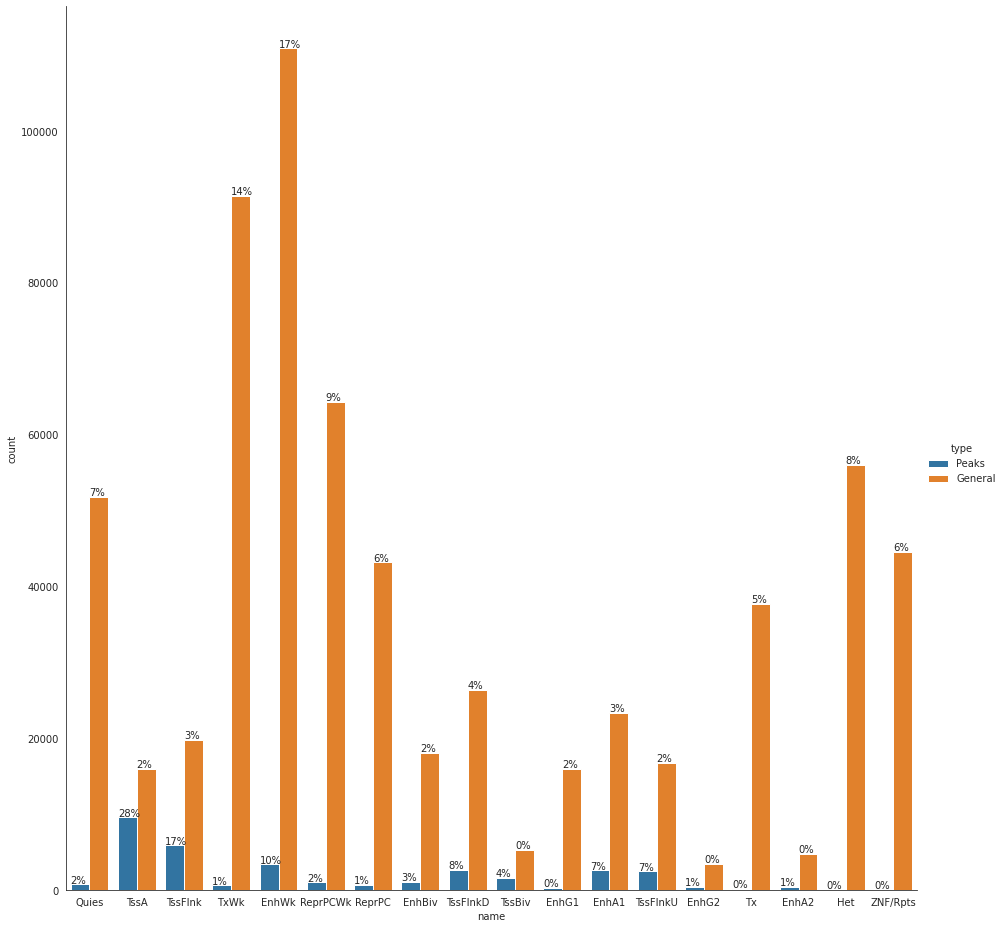

In [26]:
from itertools import product

ch_hmm['type'] = 'Peaks'
general_hmm['type'] = 'General'
tmp = pd.concat([ch_hmm, general_hmm])

class_order = tmp.name.unique().tolist()
hue_order = tmp.type.unique().tolist()
bar_order = product(hue_order, class_order)
catp = sns.catplot(
    data=tmp, kind="count", x="name", hue="type",
    order=class_order, hue_order=hue_order, height=13)

spots = zip(catp.ax.patches, bar_order)
for spot in spots:
    freq = len(tmp[(tmp['name']==spot[1][1]) & 
        (tmp['type']==spot[1][0])]) / (tmp['type']==spot[1][0]).sum()
    height = spot[0].get_height() 
    catp.ax.text(spot[0].get_x(), height+200, '{}%'.format(int(freq * 100)))
plt.savefig(config.PATHS.ASSETS/'HMM_full.png')

In [27]:
name_map = {
    'TssA': 'Tss',
    'TssFlnk': 'Tss',
    'EnhWk': 'Enh',
    'TssFlnkD': 'Tss',
    'EnhA1': 'Enh',
    'TssFlnkU': 'Tss',
    'TssBiv': 'Tss',
    'Quies': 'Quies',
    'EnhBiv': 'Enh',
    'ReprPCWk': 'Repr',
    'ReprPC': 'Repr',
    'TxWk': 'Transcription',
    'EnhG2': 'Enh',
    'EnhA2': 'Enh',
    'EnhG1': 'Enh',
    'Tx': 'Transcription',
    'Het': 'Heterochromatin',
    'ZNF/Rpts': 'ZNF_genes&repeats',
}

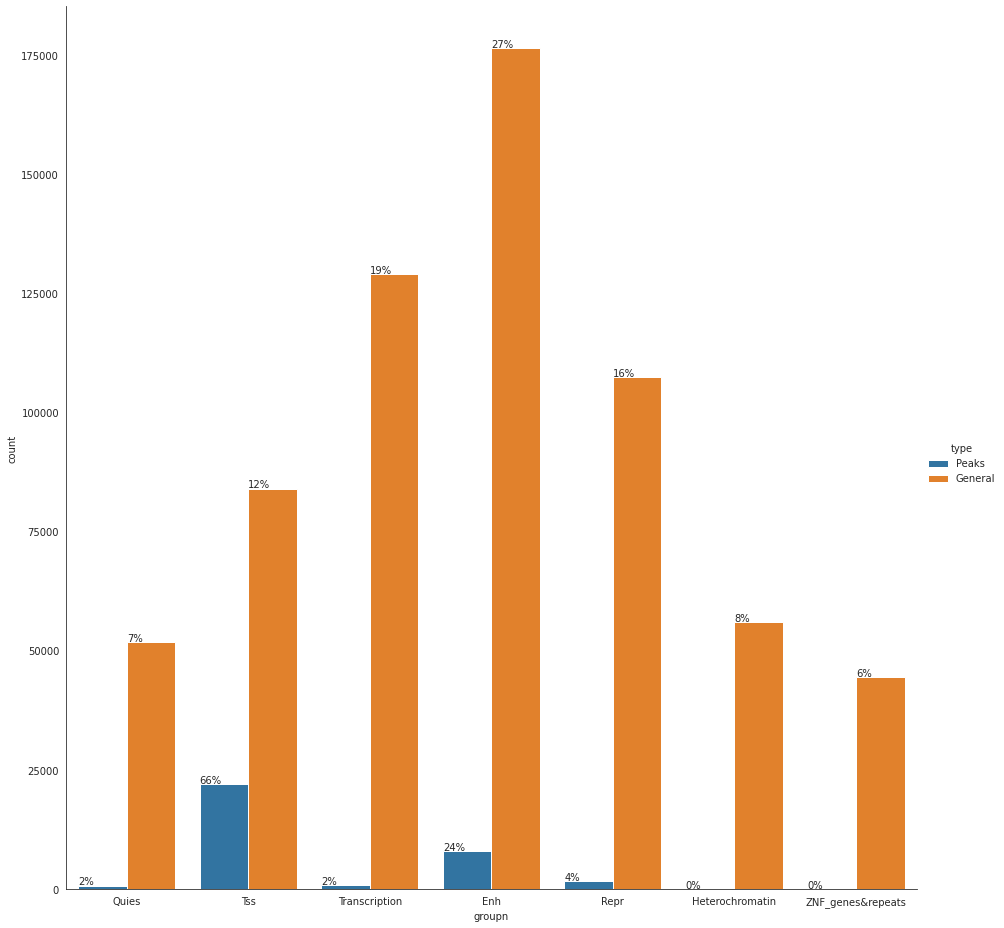

In [28]:
ch_hmm['type'] = 'Peaks'
general_hmm['type'] = 'General'
tmp = pd.concat([ch_hmm, general_hmm])
tmp['groupn'] = tmp.name.apply(lambda x: name_map[x])

class_order = tmp.groupn.unique().tolist()
hue_order = tmp.type.unique().tolist()
bar_order = product(hue_order, class_order)
catp = sns.catplot(
    data=tmp, kind="count", x="groupn", hue="type",
    order=class_order, hue_order=hue_order, height=13)

spots = zip(catp.ax.patches, bar_order)
for spot in spots:
    freq = len(tmp[(tmp['groupn']==spot[1][1]) & 
        (tmp['type']==spot[1][0])]) / (tmp['type']==spot[1][0]).sum()
    height = spot[0].get_height() 
    catp.ax.text(spot[0].get_x(), height+200, '{}%'.format(int(freq * 100)))
plt.savefig(config.PATHS.ASSETS/'HMM_groupped.png')

### Format .narrowPeak $\rightarrow$ .bed

In [44]:
! cut -f 1-6 ../data/peaks/REPS_blacklisted.bed > ../data/peaks/REPS_formatted.bed
! head ../data/peaks/REPS_formatted.bed

chr1	19819	20215	REPS_peak_1	178	.
chr1	28713	29908	REPS_peak_2	609	.
chr1	34847	35028	REPS_peak_3	35	.
chr1	135034	135506	REPS_peak_4	40	.
chr1	136079	136348	REPS_peak_5	60	.
chr1	136523	136884	REPS_peak_6	41	.
chr1	137166	138566	REPS_peak_7	134	.
chr1	138899	139113	REPS_peak_8	27	.
chr1	181616	181983	REPS_peak_9	215	.
chr1	190334	190577	REPS_peak_10	96	.


In [21]:
bedtools subtract -A -a peaks/REPS_peaks.narrowPeak -b blacklist/hg38.blacklist.bed.gz > peaks/REPS_blacklisted.bed

# SeqMiner

In [29]:
!cat ../data/peaks/REPS_peaks.narrowPeak | wc -l

37379


In [46]:
!head ../data/peaks/REPS_blacklisted.bed

chr1	19819	20215	REPS_peak_1	178	.	3.84720	20.59513	17.88456	121
chr1	28713	29908	REPS_peak_2	609	.	13.74584	64.37499	60.93768	457
chr1	34847	35028	REPS_peak_3	35	.	3.09739	5.83711	3.58172	85
chr1	135034	135506	REPS_peak_4	40	.	4.22558	6.37767	4.09493	108
chr1	136079	136348	REPS_peak_5	60	.	4.73104	8.44714	6.06927	143
chr1	136523	136884	REPS_peak_6	41	.	3.38382	6.46191	4.16961	38
chr1	137166	138566	REPS_peak_7	134	.	5.26404	16.08644	13.47995	128
chr1	138899	139113	REPS_peak_8	27	.	3.42469	4.98259	2.77580	86
chr1	181616	181983	REPS_peak_9	215	.	6.15717	24.34908	21.56016	186
chr1	190334	190577	REPS_peak_10	96	.	3.00461	12.14299	9.64393	85


In [69]:
os.makedirs(config.PATHS.SMINER, exist_ok=True)
with open(config.PATHS.SMINER/'REPS_for.bed', 'w') as wd:
    with open(config.PATHS.SMINER/'REPS_pscan.bed', 'w') as sd:
        with open(config.PATHS.PEAKS/'REPS_blacklisted.bed', 'r') as fd:
            lines = fd.readlines()
            lines = sorted(
                lines, key=lambda x: float(x.split()[-4]), reverse=True)

            for line in lines:
                tmp = line.split()
                tmp[2] = int(tmp[1]) + int(tmp[-1]) + 50
                tmp[1] = int(tmp[1]) + int(tmp[-1]) - 50
                wd.write('\t'.join(map(str, tmp[:4])) + '\n')
                tmp[1] = tmp[2] = int(tmp[1]) - 50
                sd.write('\t'.join(map(str, tmp[:4])) + '\n')

# DNase-Seq

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,colour,0
0,chr1,181400,181580,.,0,.,0.720678,-1,-1,75
1,chr1,190865,190920,.,0,.,0.390141,-1,-1,75
2,chr1,268011,268080,.,0,.,0.742352,-1,-1,75
3,chr1,727161,727287,.,0,.,0.449746,-1,-1,75
4,chr1,778660,778860,.,0,.,7.710710,-1,-1,75


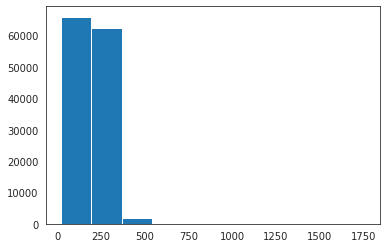

In [186]:
dnase = read_bed("../data/annotations/DNase.bed")
plt.hist(dnase.chromEnd - dnase.chromStart);
dnase.head()

In [187]:
! bedtools intersect -u -a ../data/peaks/REPS_blacklisted.bed -b ../data/annotations/DNase.bed > ../data/intersection/DNase.bed
! echo "REPS & DNase: `cat ../data/intersection/DNase.bed | wc -l`"
! bedtools subtract -A -a ../data/peaks/REPS_blacklisted.bed -b ../data/annotations/DNase.bed > ../data/intersection/NON_DNase.bed
! echo "REPS & DNase: `cat ../data/intersection/NON_DNase.bed | wc -l`"

REPS & DNase: 27148
REPS & DNase: 10230


In [19]:
names = [ 'DNase' ]
qvals = us.get_qvals(names, True)
qvals.head()

,qval,is_intersected,name,log_qval
0,89.0,True,DNase,4.488636
1,353.0,True,DNase,5.866468
2,450.0,True,DNase,6.109248
3,84.0,True,DNase,4.430817
4,1066.0,True,DNase,6.971669


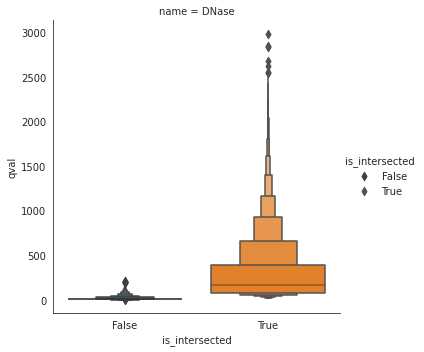

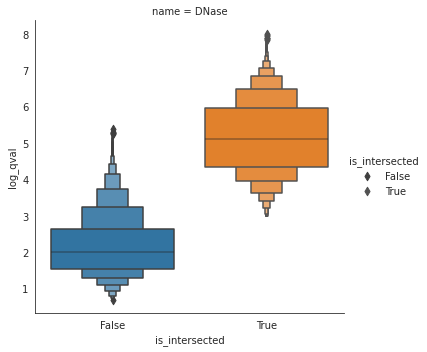

In [70]:
g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'dnase_qval_intersect.png')

g = sns.FacetGrid(qvals, col="name", hue="is_intersected", height=5, aspect=1)
g.map(sns.boxenplot, "is_intersected", "log_qval", order=[False, True])
g.add_legend();
plt.savefig(config.PATHS.ASSETS/'log_dnase_qval_intersect.png')